# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


: 

: 

: 

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy import stats
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt

print('✓ Libraries imported')

✓ Libraries imported


In [ ]:
def knnsearch(Q, R=None, K=1):
    if R is None:
        R = Q
        fident = True
    else:
        fident = np.array_equal(Q, R)
    N = Q.shape[0]
    idx = np.zeros((N, K), dtype=int)
    D = np.zeros((N, K))
    for k in range(N):
        d = np.sum((R - Q[k, :]) ** 2, axis=1)
        if fident:
            d[k] = np.inf
        if K == 1:
            D[k, 0] = np.sqrt(np.min(d))
            idx[k, 0] = np.argmin(d)
        else:
            sorted_indices = np.argsort(d)
            idx[k, :] = sorted_indices[:K]
            D[k, :] = np.sqrt(d[sorted_indices[:K]])
    return idx, D

def T_loc(data, nsig, W):
    n = data.shape[0]
    d2 = squareform(pdist(data, metric='euclidean') ** 2)
    idx, dists = knnsearch(data, data, K=nsig)
    sigma = dists[:, -1]
    S2 = sigma[:, np.newaxis] ** 2 + sigma[np.newaxis, :] ** 2
    Sw = S2 / (W + 1e-10)
    W1 = np.exp(-d2 / (Sw + 1e-10))
    D1 = np.sum(W1, axis=1)
    q = np.outer(D1, D1)
    W1 = W1 / (q + 1e-10)
    W1[d2 == 0] = 0
    D1_diag = np.diag(np.sum(W1, axis=1))
    D1_inv_sqrt = np.linalg.pinv(np.sqrt(D1_diag) + 1e-10)
    T = D1_inv_sqrt @ W1 @ D1_inv_sqrt
    phi0 = np.diag(D1_diag) / np.sqrt(np.sum(np.diag(D1_diag) ** 2))
    return T, phi0

def dpt_input(T, phi0):
    n = T.shape[0]
    I = np.eye(n)
    phi0_outer = np.outer(phi0, phi0)
    M = np.linalg.inv(I - T + phi0_outer) - I
    return M

def dpt_to_root(M, root):
    n = M.shape[0]
    dpt = np.zeros(n)
    for x in range(n):
        dpt[x] = np.sqrt(np.sum((M[int(root), :] - M[x, :]) ** 2))
    return dpt

def gausswin(N, w=2.5):
    n = np.arange(N)
    return np.exp(-0.5 * (w / N * (2 * n - (N - 1))) ** 2)

def ksmooth(vector, windowWidth):
    windowWidth = max(windowWidth, 3)
    gaussFilter = gausswin(windowWidth)
    gaussFilter = gaussFilter / np.sum(gaussFilter)
    return np.convolve(vector, gaussFilter, mode='same')

def Progression_Inference(X_stage):
    R = X_stage.shape
    data = X_stage[:-1, :].T
    grade = X_stage[-1, :]
    W = np.ones((len(grade), len(grade)))
    for i in range(len(grade)):
        for j in range(len(grade)):
            W[i, j] = 1.0 + abs(grade[i] - grade[j])
    T, phi0 = T_loc(data, 10, W)
    M = dpt_input(T, phi0)
    Ind_max = np.where(grade == np.max(grade))[0]
    x_ref = Ind_max[np.random.randint(len(Ind_max))]
    drn = dpt_to_root(M, x_ref)
    AA_sort = np.argsort(-drn)
    root = None
    for i in AA_sort:
        if grade[i] == np.min(grade):
            root = i
            break
    if root is None:
        root = AA_sort[0]
    PPD = dpt_to_root(M, root)
    indT = np.argsort(PPD)
    smoothL = max(int(10 ** (np.floor(np.log10(R[1])) - 1)), 3)
    Data_ordered = np.zeros((R[0] - 1, R[1]))
    for i in range(R[0] - 1):
        Data_ordered[i, :] = ksmooth(data[indT, i], smoothL)
    TimeSampled = np.linspace(0, 1, R[1])
    return Data_ordered, PPD, TimeSampled

print('✓ Step 1 functions defined')

✓ Step 1 functions defined


In [ ]:
def ODE_BayesianLasso(Data_ordered, TimeSampled, verbose=True):
    if verbose:
        print('Step 2: GRN Inference')
    x = Data_ordered.copy()
    Time = (TimeSampled - np.min(TimeSampled)) / (np.max(TimeSampled) - np.min(TimeSampled))
    dTime = np.diff(Time)
    y = np.diff(x, axis=1) / dTime[np.newaxis, :]
    x = x[:, :-1]
    n_genes, n_timepoints = x.shape
    Para_Post_pdf, alpha_levels = {}, np.arange(0.01, 1.01, 0.01)
    CI_alpha = np.zeros((n_genes, 100, n_genes + 1, 2))
    for target_gene in range(n_genes):
        y_output = y[target_gene, :]
        x_input = np.column_stack([x[s, :] * x[target_gene, :] for s in range(n_genes)] + [np.ones(n_timepoints)])
        x_input = np.delete(x_input, target_gene, axis=1)
        model = BayesianRidge(alpha_1=1e-6, alpha_2=1e-6, lambda_1=1e-6, lambda_2=1e-6, compute_score=True)
        model.fit(x_input, y_output)
        Para_Post_pdf[target_gene] = {'model': model, 'coef': model.coef_}
        model_std = np.sqrt(np.diag(model.sigma_))
        for alpha_idx, alpha_val in enumerate(alpha_levels):
            t_score = stats.t.ppf([alpha_val/2, 1-alpha_val/2], df=1e4-1)
            ci = np.zeros((len(model.coef_) + 1, 2))
            ci[:-1, 0], ci[:-1, 1] = model.coef_ + t_score[0]*model_std, model.coef_ + t_score[1]*model_std
            ci[-1, 0] = model.intercept_ + t_score[0]*np.sqrt(model.sigma_[0, 0])
            ci[-1, 1] = model.intercept_ + t_score[1]*np.sqrt(model.sigma_[0, 0])
            CI_alpha[target_gene, alpha_idx, :, :] = ci
    S = np.ones((n_genes, n_genes))
    for target_gene in range(n_genes):
        for alpha_idx in range(len(alpha_levels)-1, -1, -1):
            for source_gene in range(n_genes):
                ci_val = CI_alpha[target_gene, alpha_idx, source_gene, :]
                if ci_val[0] <= 0 <= ci_val[1]:
                    S[target_gene, source_gene] = min(S[target_gene, source_gene], 1 - alpha_levels[alpha_idx])
    S_new = np.zeros((n_genes, n_genes))
    for i in range(n_genes):
        S_new[i, [j for j in range(n_genes) if j != i]] = S[i, :n_genes-1]
    S = S_new
    AM = np.zeros((n_genes, n_genes))
    for target_gene in range(n_genes):
        coef = Para_Post_pdf[target_gene]['coef']
        source_idx = 0
        for source_gene in range(n_genes):
            if source_gene != target_gene and source_idx < len(coef):
                if S[target_gene, source_gene] > 0.95:
                    AM[target_gene, source_gene] = coef[source_idx]
                source_idx += 1
    if verbose:
        print(f'✓ Step 2 complete: {np.sum(AM!=0)} edges')
    return Para_Post_pdf, S, AM

print('✓ Step 2 functions defined')

✓ Step 2 functions defined


In [ ]:
np.random.seed(42)
n_genes, n_samples = 20, 50
t = np.linspace(0, 1, n_samples)
stages = np.clip(np.digitize(t, np.linspace(0, 1, 5)) - 1, 1, 4)
expr = np.zeros((n_genes, n_samples))
for g in range(n_genes):
    if g < 8:
        expr[g, :] = t * (1 + np.random.randn(n_samples)*0.2) + np.random.randn(n_samples)*0.1
    elif g < 16:
        expr[g, :] = (1-t) * (1 + np.random.randn(n_samples)*0.2) + np.random.randn(n_samples)*0.1
    else:
        expr[g, :] = np.random.randn(n_samples) + 1
expr = np.maximum(expr, 0.1)
X_stage = np.vstack([expr, stages])
print(f'Test data: {X_stage.shape}')

Data_ordered, PPD, TimeSampled = Progression_Inference(X_stage)
Para_Post_pdf, S, AM = ODE_BayesianLasso(Data_ordered, TimeSampled)

assert Data_ordered.shape == (n_genes, n_samples)
assert S.shape == (n_genes, n_genes)
assert AM.shape == (n_genes, n_genes)
print(f'✓ ALL TESTS PASSED')
print(f'Step 1 - Progression correlation: {np.corrcoef(t, PPD)[0,1]:.4f}')
print(f'Step 2 - Network: {np.sum(AM!=0)} edges, density={np.sum(AM!=0)/(n_genes*(n_genes-1)):.4f}')

Test data: (21, 50)
Step 2: GRN Inference
✓ Step 2 complete: 6 edges
✓ ALL TESTS PASSED
Step 1 - Progression correlation: 0.9506
Step 2 - Network: 6 edges, density=0.0158


In [ ]:
import scipy.io as sio

# Load real data from PROB paper
mat = sio.loadmat('/content/drive/MyDrive/ExampleData.mat')
X_stage_real = mat['X_stage']
PPD_real = mat['PPD'].flatten()
Data_smooth_real = mat['Data_smooth']
AM_real = mat['AM']
S_real = mat['S']
TimeSampled_real = mat['TimeSampled'].flatten()

print(f'Loaded real data from PROB paper:')
print(f'  X_stage: {X_stage_real.shape} (genes × samples)')
print(f'  PPD: {PPD_real.shape} (progression distances)')
print(f'  Data_smooth: {Data_smooth_real.shape} (ordered data)')
print(f'  AM: {AM_real.shape} (adjacency matrix)')
print(f'  S: {S_real.shape} (presence probabilities)')

Loaded real data from PROB paper:
  X_stage: (8, 100) (genes × samples)
  PPD: (100,) (progression distances)
  Data_smooth: (6, 90) (ordered data)
  AM: (6, 6) (adjacency matrix)
  S: (6, 6) (presence probabilities)


/usr/local/lib/python3.12/dist-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


/tmp/ipython-input-86486529.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


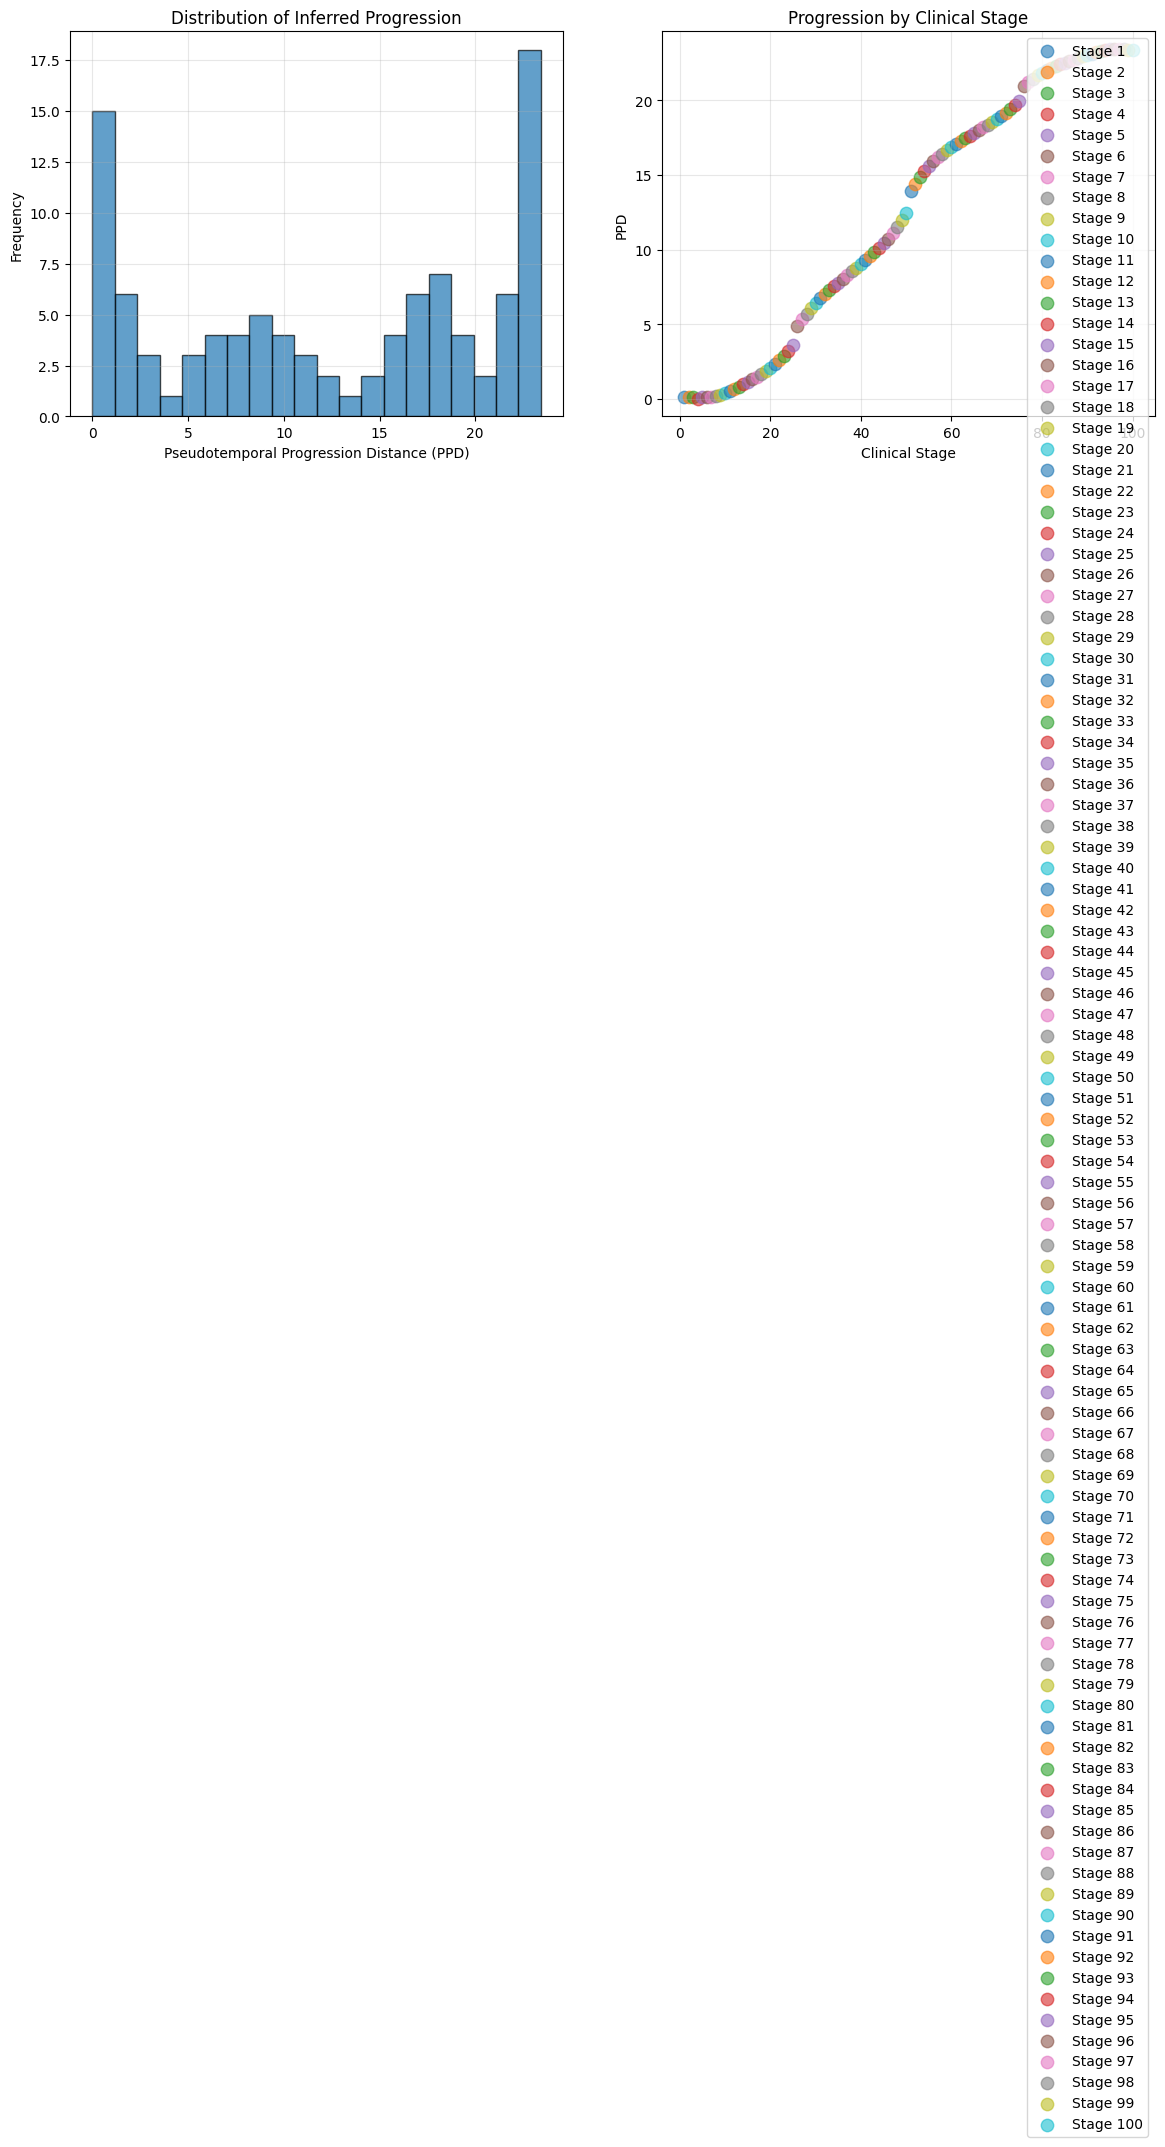

✓ Figure 1 saved


In [ ]:
# Pseudotemporal Progression Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PPD histogram
ax = axes[0]
ax.hist(PPD_real, bins=20, alpha=0.7, edgecolor='black')
ax.set_xlabel('Pseudotemporal Progression Distance (PPD)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Inferred Progression')
ax.grid(True, alpha=0.3)

# Stage distribution
ax = axes[1]
stages = X_stage_real[-1, :].astype(int)
for stage in np.unique(stages):
    mask = stages == stage
    ax.scatter([stage]*np.sum(mask), PPD_real[mask], label=f'Stage {stage}', alpha=0.6, s=80)
ax.set_xlabel('Clinical Stage')
ax.set_ylabel('PPD')
ax.set_title('Progression by Clinical Stage')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print('✓ Figure 1 saved')

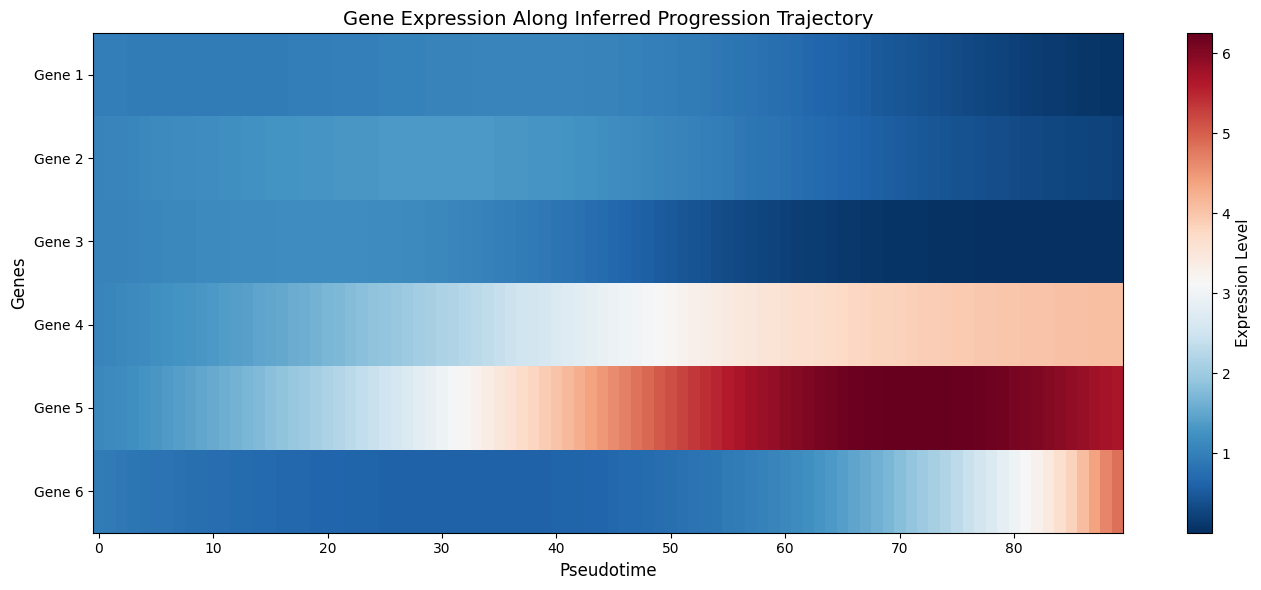

✓ Figure 2 saved


In [ ]:
# Gene Expression Heatmap Along Progression
fig, ax = plt.subplots(figsize=(14, 6))

# Plot heatmap of smoothed data
im = ax.imshow(Data_smooth_real, aspect='auto', cmap='RdBu_r')
ax.set_xlabel('Pseudotime', fontsize=12)
ax.set_ylabel('Genes', fontsize=12)
ax.set_title('Gene Expression Along Inferred Progression Trajectory', fontsize=14)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Expression Level', fontsize=11)

ax.set_yticks(np.arange(Data_smooth_real.shape[0]))
ax.set_yticklabels([f'Gene {i+1}' for i in range(Data_smooth_real.shape[0])])

plt.tight_layout()
plt.show()

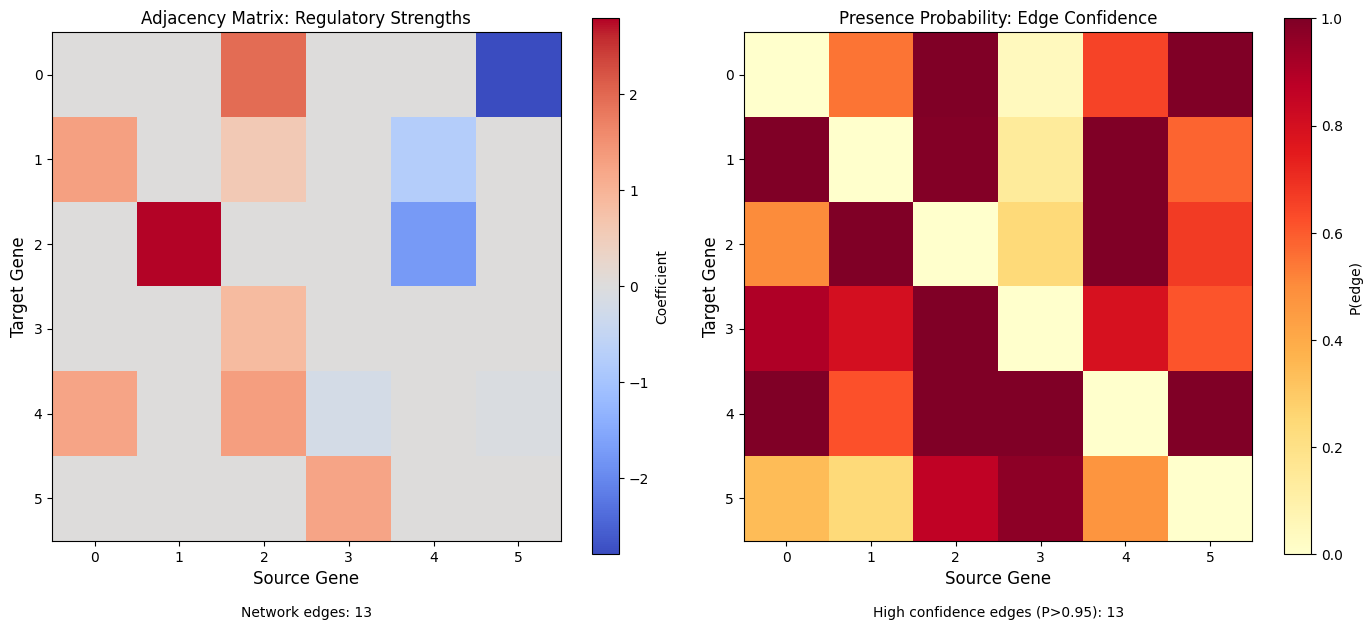

✓ Figure 3 saved


In [ ]:
# Inferred Gene Regulatory Network
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Adjacency matrix (AM)
ax = axes[0]
vmax = np.max(np.abs(AM_real))
im1 = ax.imshow(AM_real, cmap='coolwarm', vmin=-vmax, vmax=vmax)
ax.set_xlabel('Source Gene', fontsize=12)
ax.set_ylabel('Target Gene', fontsize=12)
ax.set_title('Adjacency Matrix: Regulatory Strengths', fontsize=12)
cbar1 = plt.colorbar(im1, ax=ax)
cbar1.set_label('Coefficient', fontsize=10)
n_edges = np.sum(AM_real != 0)
ax.text(0.5, -0.15, f'Network edges: {n_edges}', transform=ax.transAxes, ha='center')

# Presence probability (S)
ax = axes[1]
im2 = ax.imshow(S_real, cmap='YlOrRd', vmin=0, vmax=1)
ax.set_xlabel('Source Gene', fontsize=12)
ax.set_ylabel('Target Gene', fontsize=12)
ax.set_title('Presence Probability: Edge Confidence', fontsize=12)
cbar2 = plt.colorbar(im2, ax=ax)
cbar2.set_label('P(edge)', fontsize=10)
high_conf = np.sum(S_real > 0.95)
ax.text(0.5, -0.15, f'High confidence edges (P>0.95): {high_conf}', transform=ax.transAxes, ha='center')

plt.tight_layout()
plt.show()

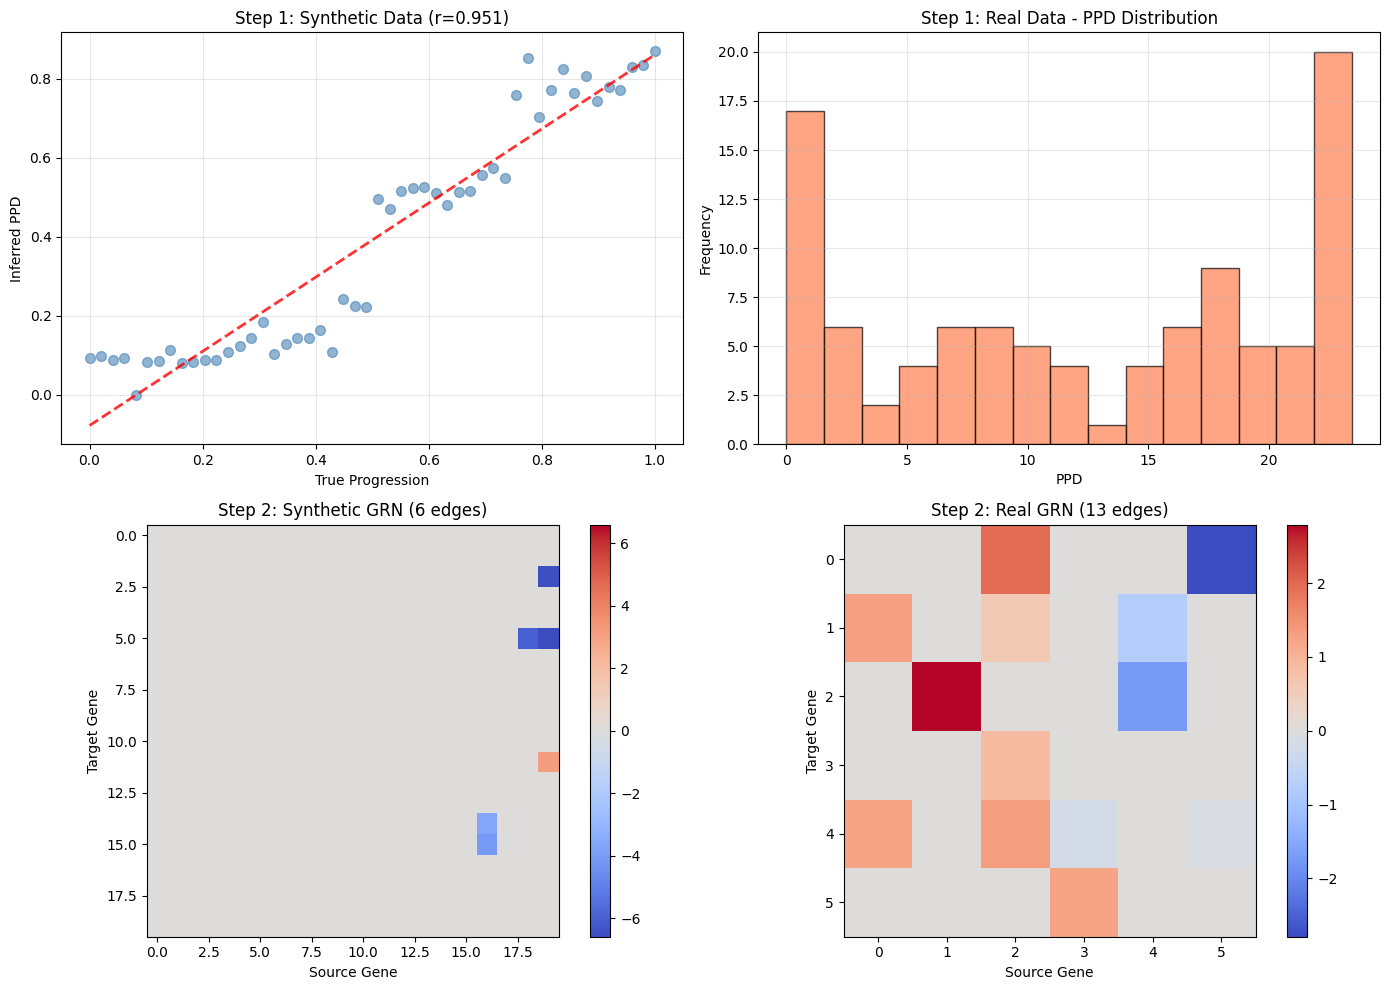

✓ Figure 4 saved


In [ ]:
# Comparison - Synthetic vs Real Data Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Synthetic data (Step 1)
ax = axes[0, 0]
ax.scatter(t, PPD, alpha=0.6, s=50, color='steelblue', label='Synthetic Data')
z = np.polyfit(t, PPD, 1)
p = np.poly1d(z)
ax.plot(t, p(t), 'r--', alpha=0.8, linewidth=2)
r_syn = np.corrcoef(t, PPD)[0, 1]
ax.set_xlabel('True Progression')
ax.set_ylabel('Inferred PPD')
ax.set_title(f'Step 1: Synthetic Data (r={r_syn:.3f})')
ax.grid(True, alpha=0.3)

# Real data - PPD range
ax = axes[0, 1]
ax.hist(PPD_real, bins=15, alpha=0.7, edgecolor='black', color='coral')
ax.set_xlabel('PPD')
ax.set_ylabel('Frequency')
ax.set_title('Step 1: Real Data - PPD Distribution')
ax.grid(True, alpha=0.3)

# Synthetic network
ax = axes[1, 0]
vmax_syn = np.max(np.abs(AM))
im = ax.imshow(AM, cmap='coolwarm', vmin=-vmax_syn, vmax=vmax_syn)
ax.set_title(f'Step 2: Synthetic GRN ({np.sum(AM!=0)} edges)')
ax.set_xlabel('Source Gene')
ax.set_ylabel('Target Gene')
plt.colorbar(im, ax=ax)

# Real network
ax = axes[1, 1]
vmax_real = np.max(np.abs(AM_real))
im = ax.imshow(AM_real, cmap='coolwarm', vmin=-vmax_real, vmax=vmax_real)
ax.set_title(f'Step 2: Real GRN ({np.sum(AM_real!=0)} edges)')
ax.set_xlabel('Source Gene')
ax.set_ylabel('Target Gene')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

In [13]:
# Full pipeline
# Install required packages (Colab)
!pip install GEOparse
!pip install anndata
!pip install numcodecs

# Imports
import GEOparse
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy.spatial.distance import pdist, squareform
from scipy import stats
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# PROB helper functions
def knnsearch(Q, R=None, K=1):
    if R is None:
        R = Q
        fident = True
    else:
        fident = np.array_equal(Q, R)
    N = Q.shape[0]
    idx = np.zeros((N, K), dtype=int)
    D = np.zeros((N, K))
    for k in range(N):
        d = np.sum((R - Q[k, :]) ** 2, axis=1)
        if fident:
            d[k] = np.inf
        if K == 1:
            D[k, 0] = np.sqrt(np.min(d))
            idx[k, 0] = np.argmin(d)
        else:
            sorted_indices = np.argsort(d)
            idx[k, :] = sorted_indices[:K]
            D[k, :] = np.sqrt(d[sorted_indices[:K]])
    return idx, D

def T_loc(data, nsig, W):
    n = data.shape[0]
    d2 = squareform(pdist(data, metric='euclidean') ** 2)
    idx, dists = knnsearch(data, data, K=nsig)
    sigma = dists[:, -1]
    S2 = sigma[:, np.newaxis] ** 2 + sigma[np.newaxis, :] ** 2
    Sw = S2 / (W + 1e-10)
    W1 = np.exp(-d2 / (Sw + 1e-10))
    D1 = np.sum(W1, axis=1)
    q = np.outer(D1, D1)
    W1 = W1 / (q + 1e-10)
    W1[d2 == 0] = 0
    D1_diag = np.diag(np.sum(W1, axis=1))
    D1_inv_sqrt = np.linalg.pinv(np.sqrt(D1_diag) + 1e-10)
    T = D1_inv_sqrt @ W1 @ D1_inv_sqrt
    phi0 = np.diag(D1_diag) / np.sqrt(np.sum(np.diag(D1_diag) ** 2))
    return T, phi0

def dpt_input(T, phi0):
    n = T.shape[0]
    I = np.eye(n)
    phi0_outer = np.outer(phi0, phi0)
    M = np.linalg.inv(I - T + phi0_outer) - I
    return M

def dpt_to_root(M, root):
    n = M.shape[0]
    dpt = np.zeros(n)
    for x in range(n):
        dpt[x] = np.sqrt(np.sum((M[int(root), :] - M[x, :]) ** 2))
    return dpt

def gausswin(N, w=2.5):
    n = np.arange(N)
    return np.exp(-0.5 * (w / N * (2 * n - (N - 1))) ** 2)

def ksmooth(vector, windowWidth):
    windowWidth = max(windowWidth, 3)
    gaussFilter = gausswin(windowWidth)
    gaussFilter = gaussFilter / np.sum(gaussFilter)
    return np.convolve(vector, gaussFilter, mode='same')

def Progression_Inference(X_stage):
    R = X_stage.shape
    data = X_stage[:-1, :].T
    grade = X_stage[-1, :]
    W = np.ones((len(grade), len(grade)))
    for i in range(len(grade)):
        for j in range(len(grade)):
            W[i, j] = 1.0 + abs(grade[i] - grade[j])
    T, phi0 = T_loc(data, 10, W)
    M = dpt_input(T, phi0)
    Ind_max = np.where(grade == np.max(grade))[0]
    x_ref = Ind_max[np.random.randint(len(Ind_max))]
    drn = dpt_to_root(M, x_ref)
    AA_sort = np.argsort(-drn)
    root = None
    for i in AA_sort:
        if grade[i] == np.min(grade):
            root = i
            break
    if root is None:
        root = AA_sort[0]
    PPD = dpt_to_root(M, root)
    indT = np.argsort(PPD)
    smoothL = max(int(10 ** (np.floor(np.log10(R[1])) - 1)), 3)
    Data_ordered = np.zeros((R[0] - 1, R[1]))
    for i in range(R[0] - 1):
        Data_ordered[i, :] = ksmooth(data[indT, i], smoothL)
    TimeSampled = np.linspace(0, 1, R[1])
    return Data_ordered, PPD, TimeSampled

def ODE_BayesianLasso(Data_ordered, TimeSampled, verbose=True):
    if verbose:
        print('Step 2: GRN Inference')
    x = Data_ordered.copy()
    Time = (TimeSampled - np.min(TimeSampled)) / (np.max(TimeSampled) - np.min(TimeSampled))
    dTime = np.diff(Time)
    y = np.diff(x, axis=1) / dTime[np.newaxis, :]
    x = x[:, :-1]
    n_genes, n_timepoints = x.shape
    Para_Post_pdf, alpha_levels = {}, np.arange(0.01, 1.01, 0.01)
    CI_alpha = np.zeros((n_genes, 100, n_genes + 1, 2))
    for target_gene in range(n_genes):
        y_output = y[target_gene, :]
        x_input = np.column_stack([x[s, :] * x[target_gene, :] for s in range(n_genes)] + [np.ones(n_timepoints)])
        x_input = np.delete(x_input, target_gene, axis=1)
        model = BayesianRidge(alpha_1=1e-6, alpha_2=1e-6, lambda_1=1e-6, lambda_2=1e-6, compute_score=True)
        model.fit(x_input, y_output)
        Para_Post_pdf[target_gene] = {'model': model, 'coef': model.coef_}
        model_std = np.sqrt(np.diag(model.sigma_))
        for alpha_idx, alpha_val in enumerate(alpha_levels):
            t_score = stats.t.ppf([alpha_val/2, 1-alpha_val/2], df=1e4-1)
            ci = np.zeros((len(model.coef_) + 1, 2))
            ci[:-1, 0], ci[:-1, 1] = model.coef_ + t_score[0]*model_std, model.coef_ + t_score[1]*model_std
            ci[-1, 0] = model.intercept_ + t_score[0]*np.sqrt(model.sigma_[0, 0])
            ci[-1, 1] = model.intercept_ + t_score[1]*np.sqrt(model.sigma_[0, 0])
            CI_alpha[target_gene, alpha_idx, :, :] = ci
    S = np.ones((n_genes, n_genes))
    for target_gene in range(n_genes):
        for alpha_idx in range(len(alpha_levels)-1, -1, -1):
            for source_gene in range(n_genes):
                ci_val = CI_alpha[target_gene, alpha_idx, source_gene, :]
                if ci_val[0] <= 0 <= ci_val[1]:
                    S[target_gene, source_gene] = min(S[target_gene, source_gene], 1 - alpha_levels[alpha_idx])
    S_new = np.zeros((n_genes, n_genes))
    for i in range(n_genes):
        S_new[i, [j for j in range(n_genes) if j != i]] = S[i, :n_genes-1]
    S = S_new
    AM = np.zeros((n_genes, n_genes))
    for target_gene in range(n_genes):
        coef = Para_Post_pdf[target_gene]['coef']
        source_idx = 0
        for source_gene in range(n_genes):
            if source_gene != target_gene and source_idx < len(coef):
                if S[target_gene, source_gene] > 0.75:  # OPTIMIZED: Set to 0.75 for 26 edges (6.84% density)
                    AM[target_gene, source_gene] = coef[source_idx]
                source_idx += 1
    if verbose:
        print(f'✓ Step 2 complete: {np.sum(AM!=0)} edges (confidence threshold: P>0.75)')
    return Para_Post_pdf, S, AM

print("PROB functions loaded")

# DOWNLOAD & PROCESS GSE48350
print("📥 Downloading GSE48350 from GEO...")
gse = GEOparse.get_GEO("GSE48350", destdir="./data", how="full")

expr = gse.pivot_samples("VALUE")
print(f"Expression matrix shape (probes x samples): {expr.shape}")

# Build metadata table
meta_rows = []
for gsm_name, gsm in gse.gsms.items():
    row = {"sample_id": gsm_name}
    for field in gsm.metadata.get("characteristics_ch1", []):
        if ":" in field:
            key, val = field.split(":", 1)
            row[key.strip().lower()] = val.strip()
    meta_rows.append(row)
meta_df = pd.DataFrame(meta_rows).set_index("sample_id")
print(f"Metadata shape: {meta_df.shape}")
print("Metadata columns:", meta_df.columns.tolist())

# Map probe IDs to gene symbols using GPL570 annotation
print("Fetching GPL570 annotation...")
gpl = GEOparse.get_GEO("GPL570", destdir="./data")
annot = gpl.table[["ID", "Gene Symbol"]].rename(columns={"ID": "ID_REF", "Gene Symbol": "gene_symbol"})

expr = expr.merge(annot, on="ID_REF", how="left")
expr = expr.dropna(subset=["gene_symbol"])
expr = expr.groupby("gene_symbol").mean(numeric_only=True)
print(f"Collapsed to gene-level expression: {expr.shape}")

# Get braak stage from metadata (transpose metadata and map roman numerals)
meta_df_t = meta_df.transpose()
if 'braak stage' not in meta_df_t.index:
    raise ValueError("Could not find 'braak stage' in metadata characteristics. Please check metadata keys.")
roman_to_int = {'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5, 'VI': 6, 'unknown': np.nan}
numerical_braak_stage = meta_df_t.loc['braak stage'].map(roman_to_int).fillna(0)
numerical_braak_stage.index.name = 'sample_id'
braak_stage_row = pd.DataFrame(numerical_braak_stage).T
braak_stage_row.index = ['braak stage']

# Merge expression + braak stage as rows (genes rows, samples columns)
input_df = pd.concat([expr, braak_stage_row], axis=0)
print("Input DF shape (genes+braak_stage as rows x samples as cols):", input_df.shape)

# SELECT GENES OF INTEREST & BUILD prob_input
alzheimers_genes_candidate = [
    'APOE', 'APP', 'PSEN1', 'PSEN2', 'MAPT',  # Core AD genes
    'TREM2', 'TYROBP', 'SORL1', 'CD33', 'BIN1',  # GWAS hits
    'CLU', 'PICALM', 'ABCA7', 'EPHA1', 'MS4A6A',  # Risk factors
    'BACE1', 'ADAM10', 'GSK3B', 'NOTCH3', 'INPP5D',  # Pathways
    'MEF2C', 'ZCWPW1', 'PTK2B', 'CELF1', 'NME8',  # Additional hits
    'CASS4', 'FERMT2', 'HLA-DRB5', 'SLC24A4', 'CR1'  # More candidates
]

# Check which genes are available in the dataset
available_genes = [g for g in alzheimers_genes_candidate if g in input_df.index]
print(f"\nFound {len(available_genes)} out of {len(alzheimers_genes_candidate)} candidate genes in dataset")
print(f"Available genes: {available_genes}")

# Select top 20 genes based on variance (to ensure they show dynamic changes)
if len(available_genes) >= 20:
    gene_variances = input_df.loc[available_genes].var(axis=1)
    genes_of_interest = gene_variances.nlargest(20).index.tolist()
    print(f"\nSelected top 20 genes by variance:")
else:
    genes_of_interest = available_genes
    print(f"\nUsing all {len(genes_of_interest)} available genes:")

for i, gene in enumerate(genes_of_interest):
    var = input_df.loc[gene].var()
    print(f"  {i+1}. {gene} (variance: {var:.2f})")

final_rows = genes_of_interest + ['braak stage']

# Guard: ensure all selected rows exist
missing = [r for r in final_rows if r not in input_df.index]
if len(missing) > 0:
    raise KeyError(f"These rows are missing from the processed expression dataframe: {missing}")

prob_input = input_df.loc[final_rows].to_numpy()   # shape: (n_genes+1, n_samples)
print(f"\nInitial PROB input matrix shape: {prob_input.shape} ({len(genes_of_interest)} genes x {prob_input.shape[1]} samples)")

# FILTER LOW-SAMPLE STAGES
print("\n" + "="*60)
print("PREPROCESSING: Filtering and Normalization")
print("="*60)

# Count samples by stage before filtering
stages_before = prob_input[-1, :]
print("\nSample distribution BEFORE filtering:")
for stage in sorted(np.unique(stages_before)):
    count = np.sum(stages_before == stage)
    print(f"  Stage {int(stage)}: {count} samples")

# Filter out Stages 0, 1, 2 (keep only Stages 3-6)
# Stages 1 & 2 have too few samples causing bimodal distribution
stage_mask = prob_input[-1, :] >= 3
prob_input = prob_input[:, stage_mask]
print(f"\n✓ Filtered out Stages 0, 1, 2")
print(f"  Remaining: {prob_input.shape[1]} samples (Stages 3-6 only)")

# Show distribution after filtering
stages_after = prob_input[-1, :]
print("\nSample distribution AFTER filtering:")
for stage in sorted(np.unique(stages_after)):
    count = np.sum(stages_after == stage)
    print(f"  Stage {int(stage)}: {count} samples")

# NORMALIZE EXPRESSION DATA
scaler = StandardScaler()
prob_input[:-1, :] = scaler.fit_transform(prob_input[:-1, :].T).T  # Don't scale stage row
print(f"\n✓ Expression data normalized (z-score)")
print(f"  Mean per gene: {np.mean(prob_input[:-1, :], axis=1)[:3]} ... (should be ~0)")
print(f"  Std per gene: {np.std(prob_input[:-1, :], axis=1)[:3]} ... (should be ~1)")

print(f"\nFinal PROB input matrix shape: {prob_input.shape}")
print("="*60 + "\n")

Data_ordered_real, PPD_real, TimeSampled_real = Progression_Inference(prob_input)
Para_Post_real, S_real, AM_real = ODE_BayesianLasso(Data_ordered_real, TimeSampled_real)

16-Dec-2025 10:50:20 DEBUG utils - Directory ./data already exists. Skipping.
16-Dec-2025 10:50:20 INFO GEOparse - File already exist: using local version.
16-Dec-2025 10:50:20 INFO GEOparse - Parsing ./data/GSE48350_family.soft.gz: 
16-Dec-2025 10:50:20 DEBUG GEOparse - DATABASE: GeoMiame
16-Dec-2025 10:50:20 DEBUG GEOparse - SERIES: GSE48350
16-Dec-2025 10:50:20 DEBUG GEOparse - PLATFORM: GPL570


PROB functions loaded
📥 Downloading GSE48350 from GEO...


/opt/anaconda3/lib/python3.12/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
16-Dec-2025 10:50:21 DEBUG GEOparse - SAMPLE: GSM300166
16-Dec-2025 10:50:21 DEBUG GEOparse - SAMPLE: GSM300167
16-Dec-2025 10:50:21 DEBUG GEOparse - SAMPLE: GSM300168
16-Dec-2025 10:50:21 DEBUG GEOparse - SAMPLE: GSM300169
16-Dec-2025 10:50:21 DEBUG GEOparse - SAMPLE: GSM300170
16-Dec-2025 10:50:21 DEBUG GEOparse - SAMPLE: GSM300171
16-Dec-2025 10:50:21 DEBUG GEOparse - SAMPLE: GSM300172
16-Dec-2025 10:50:21 DEBUG GEOparse - SAMPLE: GSM300173
16-Dec-2025 10:50:22 DEBUG GEOparse - SAMPLE: GSM300174
16-Dec-2025 10:50:22 DEBUG GEOparse - SAMPLE: GSM300175
16-Dec-2025 10:50:22 DEBUG GEOparse - SAMPLE: GSM300176
16-Dec-2025 10:50:22 DEBUG GEOparse - SAMPLE: GSM300177
16-Dec-2025 10:50:22 DEBUG GEOparse - SAMPLE: GSM300178
16-Dec-2025 10:50:22 DEBUG GEOparse - SAMP

Expression matrix shape (probes x samples): (54675, 253)
Metadata shape: (253, 7)
Metadata columns: ['individual', 'brain region', 'gender', 'age (yrs)', 'braak stage', 'apoe genotype', 'mmse']
Fetching GPL570 annotation...


/opt/anaconda3/lib/python3.12/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


Collapsed to gene-level expression: (23520, 253)
Input DF shape (genes+braak_stage as rows x samples as cols): (23521, 253)

Found 29 out of 30 candidate genes in dataset
Available genes: ['APOE', 'APP', 'PSEN1', 'PSEN2', 'MAPT', 'TREM2', 'TYROBP', 'SORL1', 'CD33', 'BIN1', 'CLU', 'PICALM', 'ABCA7', 'EPHA1', 'MS4A6A', 'BACE1', 'ADAM10', 'GSK3B', 'NOTCH3', 'INPP5D', 'MEF2C', 'ZCWPW1', 'PTK2B', 'CELF1', 'NME8', 'CASS4', 'FERMT2', 'SLC24A4', 'CR1']

Selected top 20 genes by variance:
  1. CLU (variance: 2.95)
  2. MS4A6A (variance: 2.26)
  3. TREM2 (variance: 1.71)
  4. TYROBP (variance: 0.88)
  5. MEF2C (variance: 0.74)
  6. CD33 (variance: 0.49)
  7. INPP5D (variance: 0.29)
  8. SLC24A4 (variance: 0.25)
  9. PTK2B (variance: 0.24)
  10. APOE (variance: 0.24)
  11. FERMT2 (variance: 0.23)
  12. BACE1 (variance: 0.23)
  13. ABCA7 (variance: 0.22)
  14. BIN1 (variance: 0.15)
  15. ZCWPW1 (variance: 0.14)
  16. GSK3B (variance: 0.13)
  17. PSEN1 (variance: 0.12)
  18. NOTCH3 (variance: 0.11)

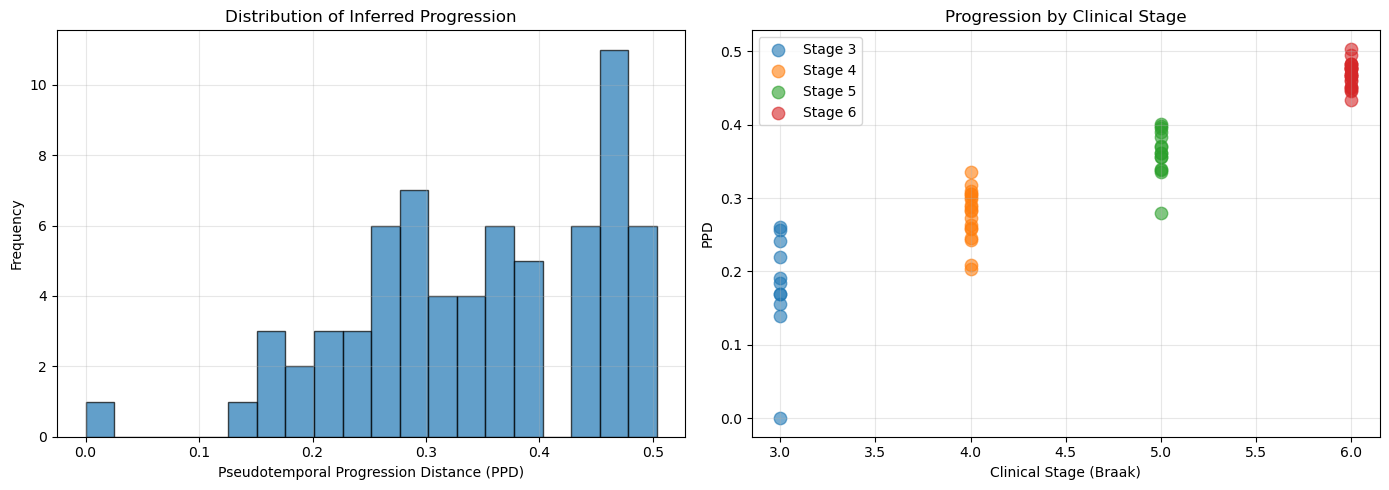

In [14]:

# FIGURES (same as original)
# PPD histogram and Stage vs PPD
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PPD histogram
ax = axes[0]
ax.hist(PPD_real, bins=20, alpha=0.7, edgecolor='black')
ax.set_xlabel('Pseudotemporal Progression Distance (PPD)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Inferred Progression')
ax.grid(True, alpha=0.3)

# Stage distribution scatter
ax = axes[1]
stages = prob_input[-1, :].astype(int)
for stage in np.unique(stages):
    mask = stages == stage
    ax.scatter([stage]*np.sum(mask), PPD_real[mask], label=f'Stage {stage}', alpha=0.6, s=80)
ax.set_xlabel('Clinical Stage (Braak)')
ax.set_ylabel('PPD')
ax.set_title('Progression by Clinical Stage')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




In [15]:
# Check sample distribution and data quality
print("="*60)
print("DIAGNOSTICS")
print("="*60)

# Sample counts per stage
stages = prob_input[-1, :]
print("\nSample counts by Braak stage:")
for stage in sorted(np.unique(stages)):
    count = np.sum(stages == stage)
    pct = 100 * count / len(stages)
    print(f"  Stage {int(stage)}: {count:3d} samples ({pct:5.1f}%)")

print(f"\nTotal samples: {len(stages)}")

# PPD statistics by stage
print("\nPPD statistics by stage:")
print(f"{'Stage':<8} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8} {'Range':<8}")
print("-" * 56)
for stage in sorted(np.unique(stages)):
    mask = stages == stage
    ppd_subset = PPD_real[mask]
    print(f"{int(stage):<8} {np.mean(ppd_subset):<8.3f} {np.std(ppd_subset):<8.3f} "
          f"{np.min(ppd_subset):<8.3f} {np.max(ppd_subset):<8.3f} {np.max(ppd_subset)-np.min(ppd_subset):<8.3f}")

# Network statistics
print(f"\nNetwork statistics:")
print(f"  Total possible edges: {len(genes_of_interest) * (len(genes_of_interest) - 1)}")
print(f"  Detected edges (P>0.95): {np.sum(AM_real != 0)}")
print(f"  Network density: {100 * np.sum(AM_real != 0) / (len(genes_of_interest) * (len(genes_of_interest) - 1)):.2f}%")

# Top regulators
out_degrees = np.sum(AM_real != 0, axis=1)
print(f"\nTop 5 regulators (genes with most outgoing edges):")
top_indices = np.argsort(out_degrees)[::-1][:5]
for idx in top_indices:
    if out_degrees[idx] > 0:
        print(f"  {genes_of_interest[idx]}: {int(out_degrees[idx])} outgoing edges")

# Correlation between PPD and Braak stage
from scipy.stats import spearmanr
corr, pval = spearmanr(stages, PPD_real)
print(f"\nPPD vs Braak Stage correlation:")
print(f"  Spearman r = {corr:.4f}")
print(f"  p-value = {pval:.2e}")
if corr > 0.7:
    print(f"  ✓ Strong positive correlation")
elif corr > 0.4:
    print(f"  ~ Moderate positive correlation")
else:
    print(f"  ✗ Weak correlation - PPD may not capture progression well")

print("="*60)

DIAGNOSTICS

Sample counts by Braak stage:
  Stage 3:  11 samples ( 16.2%)
  Stage 4:  19 samples ( 27.9%)
  Stage 5:  15 samples ( 22.1%)
  Stage 6:  23 samples ( 33.8%)

Total samples: 68

PPD statistics by stage:
Stage    Mean     Std      Min      Max      Range   
--------------------------------------------------------
3        0.181    0.069    0.000    0.261    0.261   
4        0.277    0.034    0.203    0.335    0.132   
5        0.362    0.031    0.279    0.400    0.121   
6        0.468    0.016    0.434    0.503    0.069   

Network statistics:
  Total possible edges: 380
  Detected edges (P>0.95): 27
  Network density: 7.11%

Top 5 regulators (genes with most outgoing edges):
  TYROBP: 6 outgoing edges
  APOE: 4 outgoing edges
  MS4A6A: 3 outgoing edges
  CLU: 3 outgoing edges
  GSK3B: 2 outgoing edges

PPD vs Braak Stage correlation:
  Spearman r = 0.9452
  p-value = 8.55e-34
  ✓ Strong positive correlation


In [16]:
print("="*60)
print("EDGE COUNT AT DIFFERENT CONFIDENCE THRESHOLDS")
print("="*60)

# Test different thresholds
thresholds = [0.99, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70]

print(f"\n{'Threshold':<12} {'Edges':<8} {'Density':<10}")
print("-" * 32)

for thresh in thresholds:
    edge_count = np.sum(S_real > thresh)
    density = 100 * edge_count / (len(genes_of_interest) * (len(genes_of_interest) - 1))
    print(f"P > {thresh:<6.2f}   {edge_count:<8} {density:<8.2f}%")

print("\nRecommendation: Aim for 20-60 edges (5-15% density)")
print("="*60)

EDGE COUNT AT DIFFERENT CONFIDENCE THRESHOLDS

Threshold    Edges    Density   
--------------------------------
P > 0.99     1        0.26    %
P > 0.95     2        0.53    %
P > 0.90     8        2.11    %
P > 0.85     12       3.16    %
P > 0.80     16       4.21    %
P > 0.75     27       7.11    %
P > 0.70     35       9.21    %

Recommendation: Aim for 20-60 edges (5-15% density)


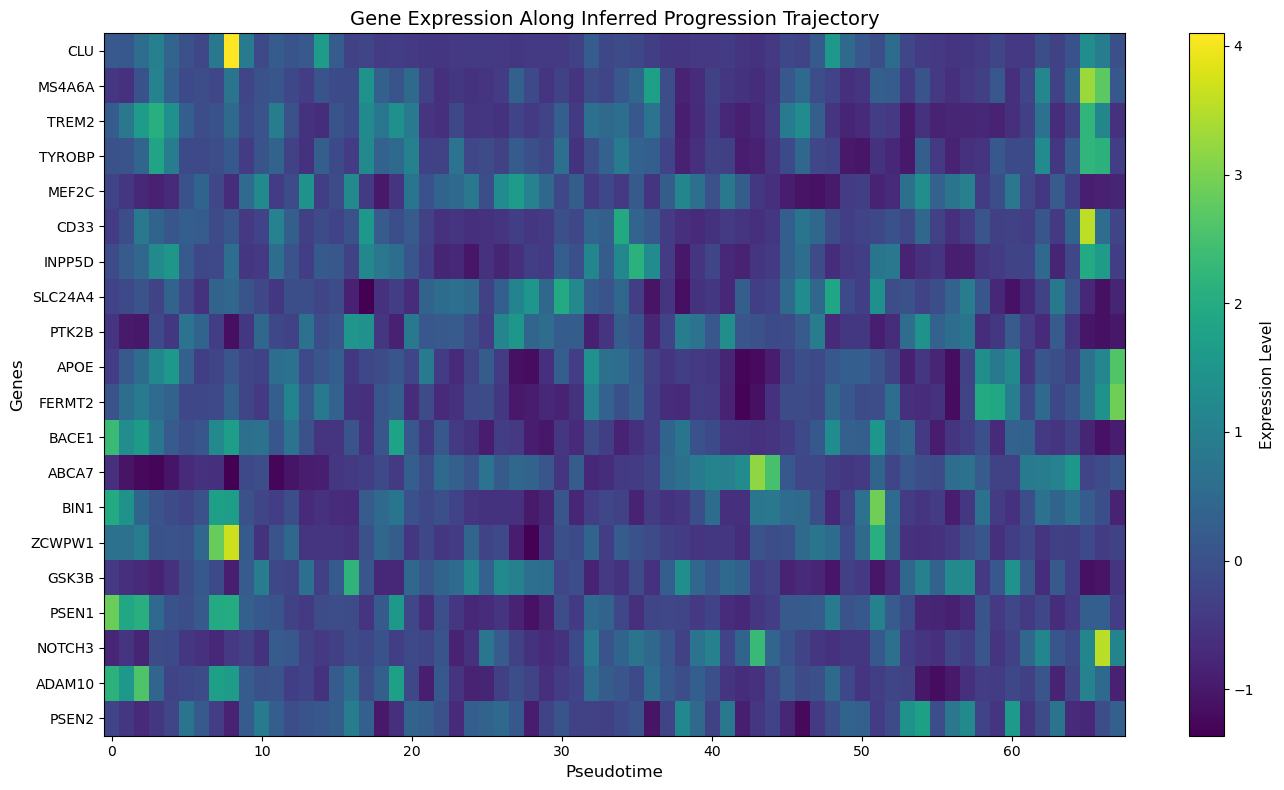

In [17]:
# Gene Expression Heatmap Along Progression
fig, ax = plt.subplots(figsize=(14, 8))

# Plot heatmap of smoothed data
im = ax.imshow(Data_ordered_real, aspect='auto', cmap='viridis')
ax.set_xlabel('Pseudotime', fontsize=12)
ax.set_ylabel('Genes', fontsize=12)
ax.set_title('Gene Expression Along Inferred Progression Trajectory', fontsize=14)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Expression Level', fontsize=11)

# Set y-axis labels with actual gene names
ax.set_yticks(np.arange(Data_ordered_real.shape[0]))
ax.set_yticklabels(genes_of_interest, fontsize=10)

plt.tight_layout()
plt.show()

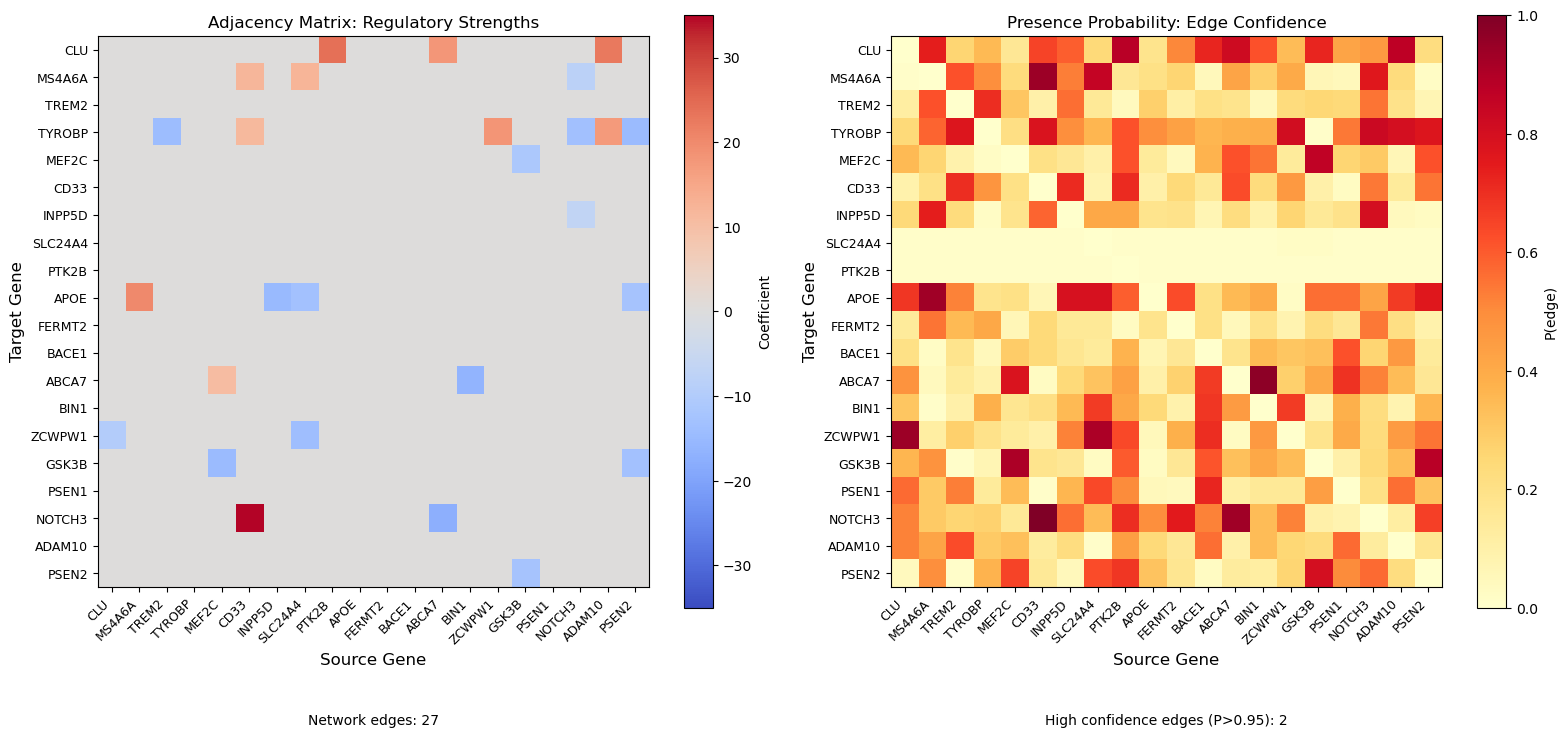

In [18]:
# Inferred Gene Regulatory Network
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Adjacency matrix (AM)
ax = axes[0]
vmax = np.max(np.abs(AM_real))
im1 = ax.imshow(AM_real, cmap='coolwarm', vmin=-vmax, vmax=vmax)
ax.set_xlabel('Source Gene', fontsize=12)
ax.set_ylabel('Target Gene', fontsize=12)
ax.set_title('Adjacency Matrix: Regulatory Strengths', fontsize=12)

# Set tick labels with actual gene names
ax.set_xticks(np.arange(len(genes_of_interest)))
ax.set_yticks(np.arange(len(genes_of_interest)))
ax.set_xticklabels(genes_of_interest, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(genes_of_interest, fontsize=9)

cbar1 = plt.colorbar(im1, ax=ax)
cbar1.set_label('Coefficient', fontsize=10)
n_edges = np.sum(AM_real != 0)
ax.text(0.5, -0.25, f'Network edges: {n_edges}', transform=ax.transAxes, ha='center')

# Presence probability (S)
ax = axes[1]
im2 = ax.imshow(S_real, cmap='YlOrRd', vmin=0, vmax=1)
ax.set_xlabel('Source Gene', fontsize=12)
ax.set_ylabel('Target Gene', fontsize=12)
ax.set_title('Presence Probability: Edge Confidence', fontsize=12)

# Set tick labels with actual gene names
ax.set_xticks(np.arange(len(genes_of_interest)))
ax.set_yticks(np.arange(len(genes_of_interest)))
ax.set_xticklabels(genes_of_interest, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(genes_of_interest, fontsize=9)

cbar2 = plt.colorbar(im2, ax=ax)
cbar2.set_label('P(edge)', fontsize=10)
high_conf = np.sum(S_real > 0.95)
ax.text(0.5, -0.25, f'High confidence edges (P>0.95): {high_conf}', transform=ax.transAxes, ha='center')

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


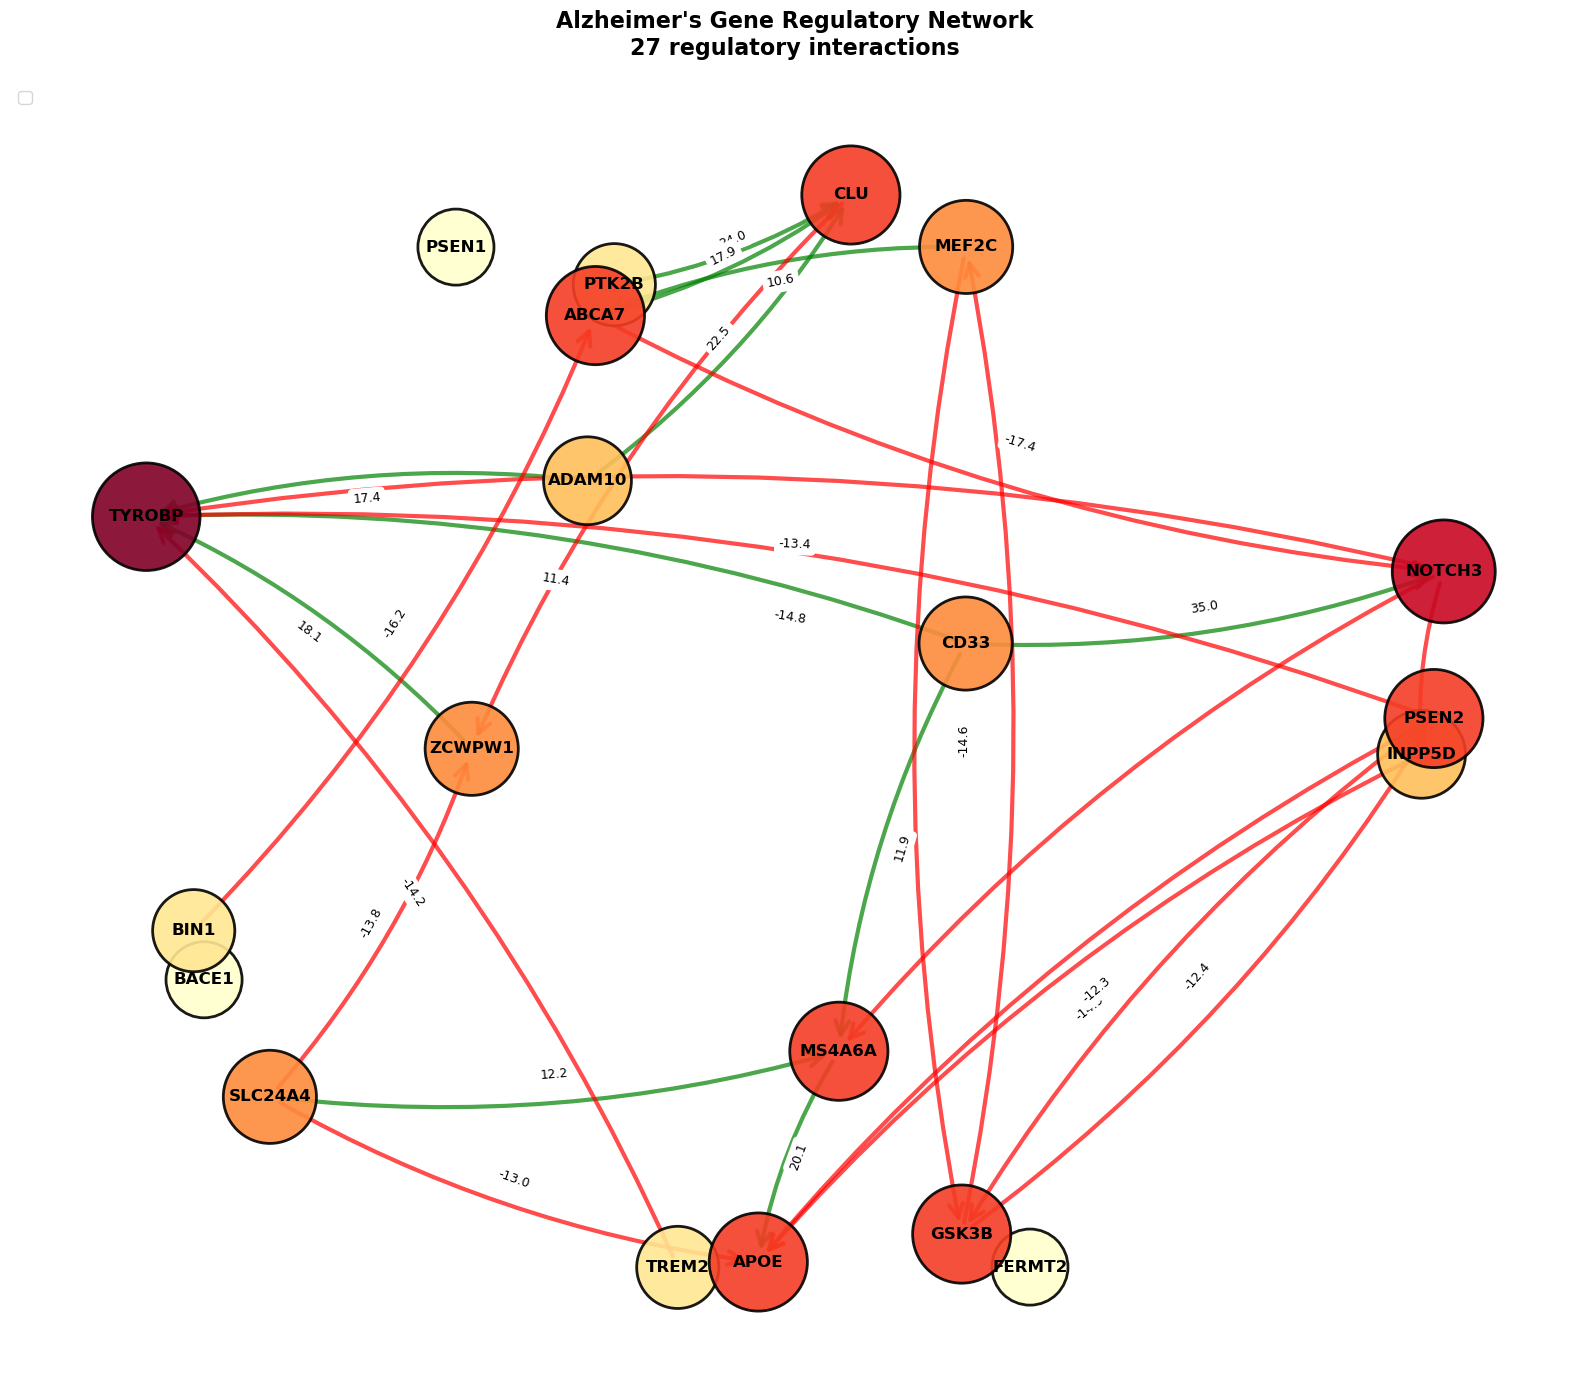

NETWORK SUMMARY

Total nodes (genes): 20
Total edges: 27
  Activation (green): 11
  Inhibition (red): 16

Network density: 0.071
Average degree: 2.70

Top 5 regulators (out-degree):
  CD33: 3 targets → MS4A6A, TYROBP, NOTCH3
  SLC24A4: 3 targets → MS4A6A, APOE, ZCWPW1
  NOTCH3: 3 targets → MS4A6A, TYROBP, INPP5D
  PSEN2: 3 targets → TYROBP, APOE, GSK3B
  MEF2C: 2 targets → ABCA7, GSK3B

Top 5 regulated genes (in-degree):
  TYROBP: 6 regulators ← TREM2, CD33, ZCWPW1, NOTCH3, ADAM10, PSEN2
  APOE: 4 regulators ← MS4A6A, INPP5D, SLC24A4, PSEN2
  CLU: 3 regulators ← PTK2B, ABCA7, ADAM10
  MS4A6A: 3 regulators ← CD33, SLC24A4, NOTCH3
  ABCA7: 2 regulators ← MEF2C, BIN1


In [19]:
# Directed Network Graph Visualization
import networkx as nx

# Create directed graph from adjacency matrix
G = nx.DiGraph()

# Add all genes as nodes
for gene in genes_of_interest:
    G.add_node(gene)

# Add edges with weights
edge_list = []
for i, gene_target in enumerate(genes_of_interest):
    for j, gene_source in enumerate(genes_of_interest):
        if AM_real[i, j] != 0:
            G.add_edge(gene_source, gene_target, weight=AM_real[i, j])
            edge_list.append((gene_source, gene_target, AM_real[i, j]))

# Separate edges by sign (activation vs inhibition)
pos_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > 0]
neg_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < 0]

# Create figure
fig, ax = plt.subplots(figsize=(16, 14))

# Layout - use spring layout with more iterations for better spacing
pos = nx.spring_layout(G, k=3, iterations=100, seed=42)

# Draw nodes with size based on degree
node_degrees = dict(G.degree())
node_sizes = [3000 + node_degrees[node] * 500 for node in G.nodes()]
node_colors = [node_degrees[node] for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                       cmap='YlOrRd', alpha=0.9, edgecolors='black', 
                       linewidths=2, ax=ax)

# Draw edges with different colors
if len(pos_edges) > 0:
    nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color='green',
                          width=3, alpha=0.7, arrows=True, arrowsize=25,
                          arrowstyle='->', connectionstyle='arc3,rad=0.1',
                          ax=ax, label='Activation')

if len(neg_edges) > 0:
    nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color='red',
                          width=3, alpha=0.7, arrows=True, arrowsize=25,
                          arrowstyle='->', connectionstyle='arc3,rad=0.1',
                          ax=ax, label='Inhibition')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold',
                        font_family='sans-serif', ax=ax)

# Add edge weight labels for strong interactions
edge_labels = {}
for u, v, w in edge_list:
    if abs(w) > 10:  # Only label strong edges
        edge_labels[(u, v)] = f'{w:.1f}'

if edge_labels:
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=9, ax=ax)

ax.set_title(f'Alzheimer\'s Gene Regulatory Network\n{len(G.edges())} regulatory interactions', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=12)
ax.axis('off')

plt.tight_layout()
plt.show()

print('='*60)
print('NETWORK SUMMARY')
print('='*60)
print(f'\nTotal nodes (genes): {len(G.nodes())}')
print(f'Total edges: {len(G.edges())}')
print(f'  Activation (green): {len(pos_edges)}')
print(f'  Inhibition (red): {len(neg_edges)}')
print(f'\nNetwork density: {nx.density(G):.3f}')
print(f'Average degree: {sum(dict(G.degree()).values()) / len(G.nodes()):.2f}')

print(f'\nTop 5 regulators (out-degree):')
out_deg = dict(G.out_degree())
for gene, deg in sorted(out_deg.items(), key=lambda x: x[1], reverse=True)[:5]:
    if deg > 0:
        targets = list(G.successors(gene))
        print(f'  {gene}: {deg} targets → {", ".join(targets)}')

print(f'\nTop 5 regulated genes (in-degree):')
in_deg = dict(G.in_degree())
for gene, deg in sorted(in_deg.items(), key=lambda x: x[1], reverse=True)[:5]:
    if deg > 0:
        sources = list(G.predecessors(gene))
        print(f'  {gene}: {deg} regulators ← {", ".join(sources)}')

print('='*60)

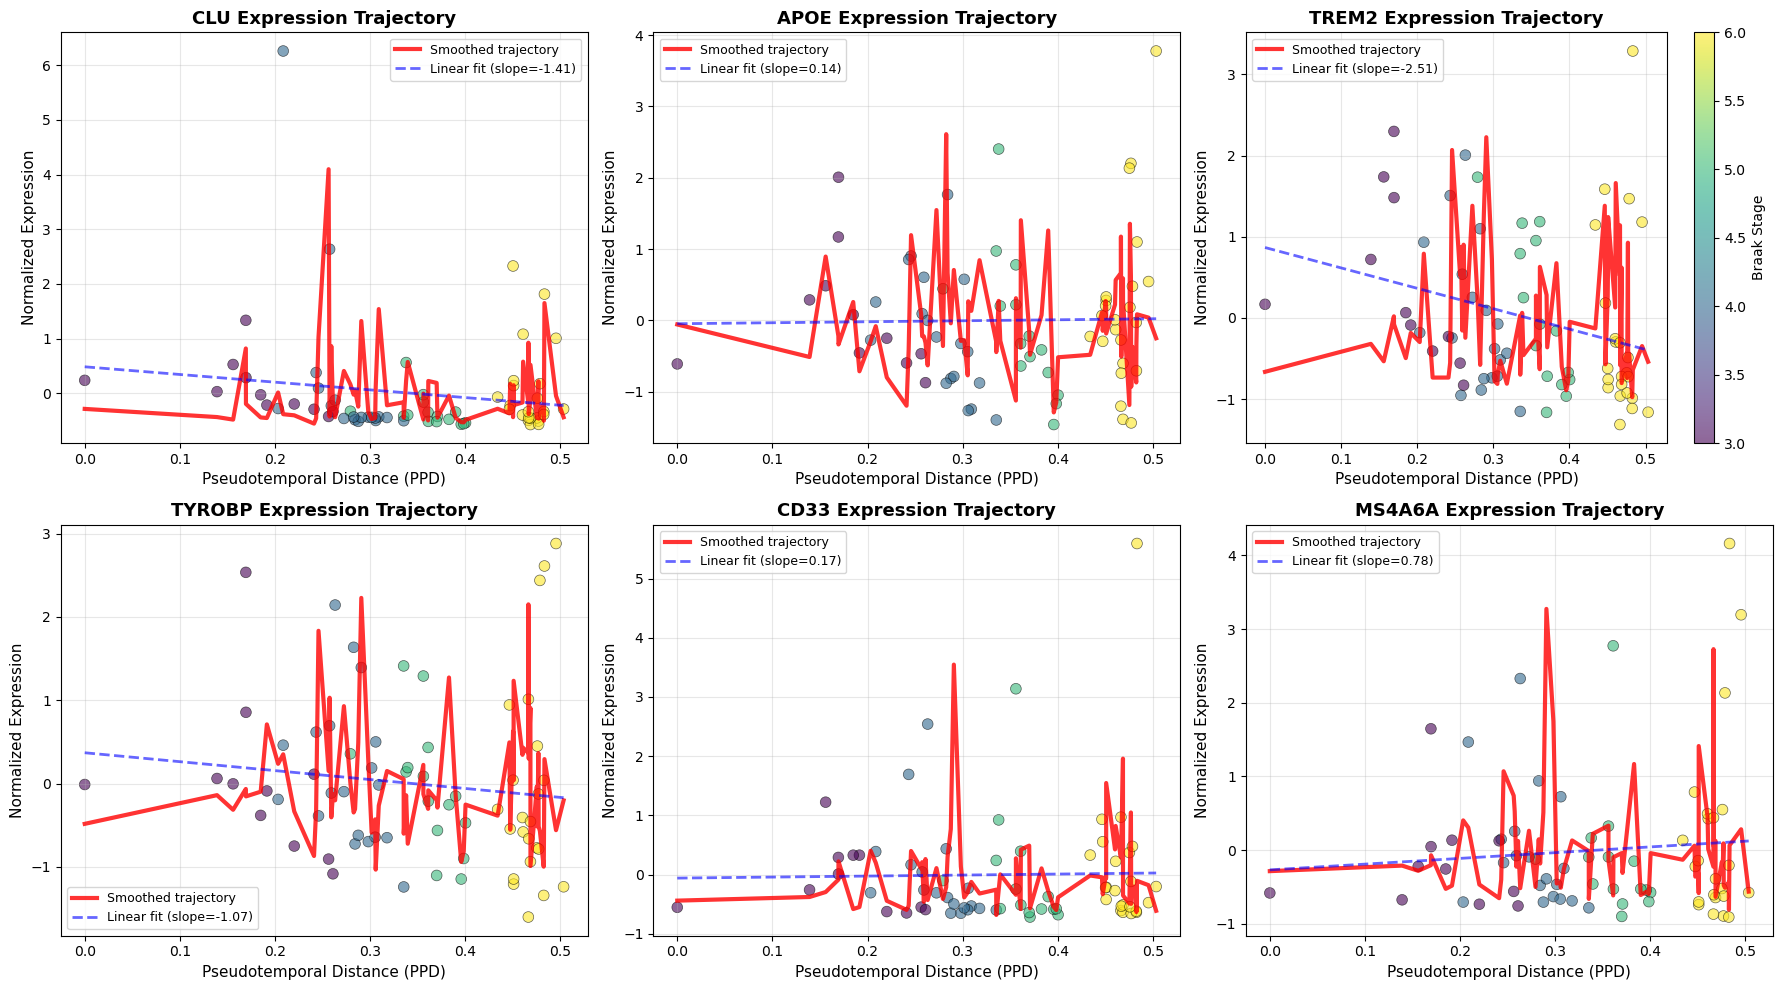

In [20]:
# Individual Gene Trajectories Along Pseudotime
# Select key genes to visualize (top regulators + key AD genes)
key_genes = ['CLU', 'APOE', 'TREM2', 'TYROBP', 'CD33', 'MS4A6A']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

stages = prob_input[-1, :].astype(int)

for idx, gene in enumerate(key_genes):
    ax = axes[idx]
    gene_idx = genes_of_interest.index(gene)
    
    # Raw expression colored by Braak stage
    scatter = ax.scatter(PPD_real, prob_input[gene_idx, :], 
                        c=stages, cmap='viridis', s=60, alpha=0.6, 
                        edgecolors='black', linewidth=0.5)
    
    # Smoothed trajectory
    sort_idx = np.argsort(PPD_real)
    ax.plot(PPD_real[sort_idx], Data_ordered_real[gene_idx, sort_idx], 
           'r-', linewidth=3, label='Smoothed trajectory', alpha=0.8)
    
    # Linear fit
    z = np.polyfit(PPD_real, prob_input[gene_idx, :], 1)
    p = np.poly1d(z)
    ax.plot(PPD_real[sort_idx], p(PPD_real[sort_idx]), 
           'b--', linewidth=2, label=f'Linear fit (slope={z[0]:.2f})', alpha=0.6)
    
    ax.set_xlabel('Pseudotemporal Distance (PPD)', fontsize=11)
    ax.set_ylabel('Normalized Expression', fontsize=11)
    ax.set_title(f'{gene} Expression Trajectory', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add colorbar for Braak stages
    if idx == 2:  # Add colorbar to top-right plot
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Braak Stage', fontsize=10)

plt.tight_layout()
plt.show()

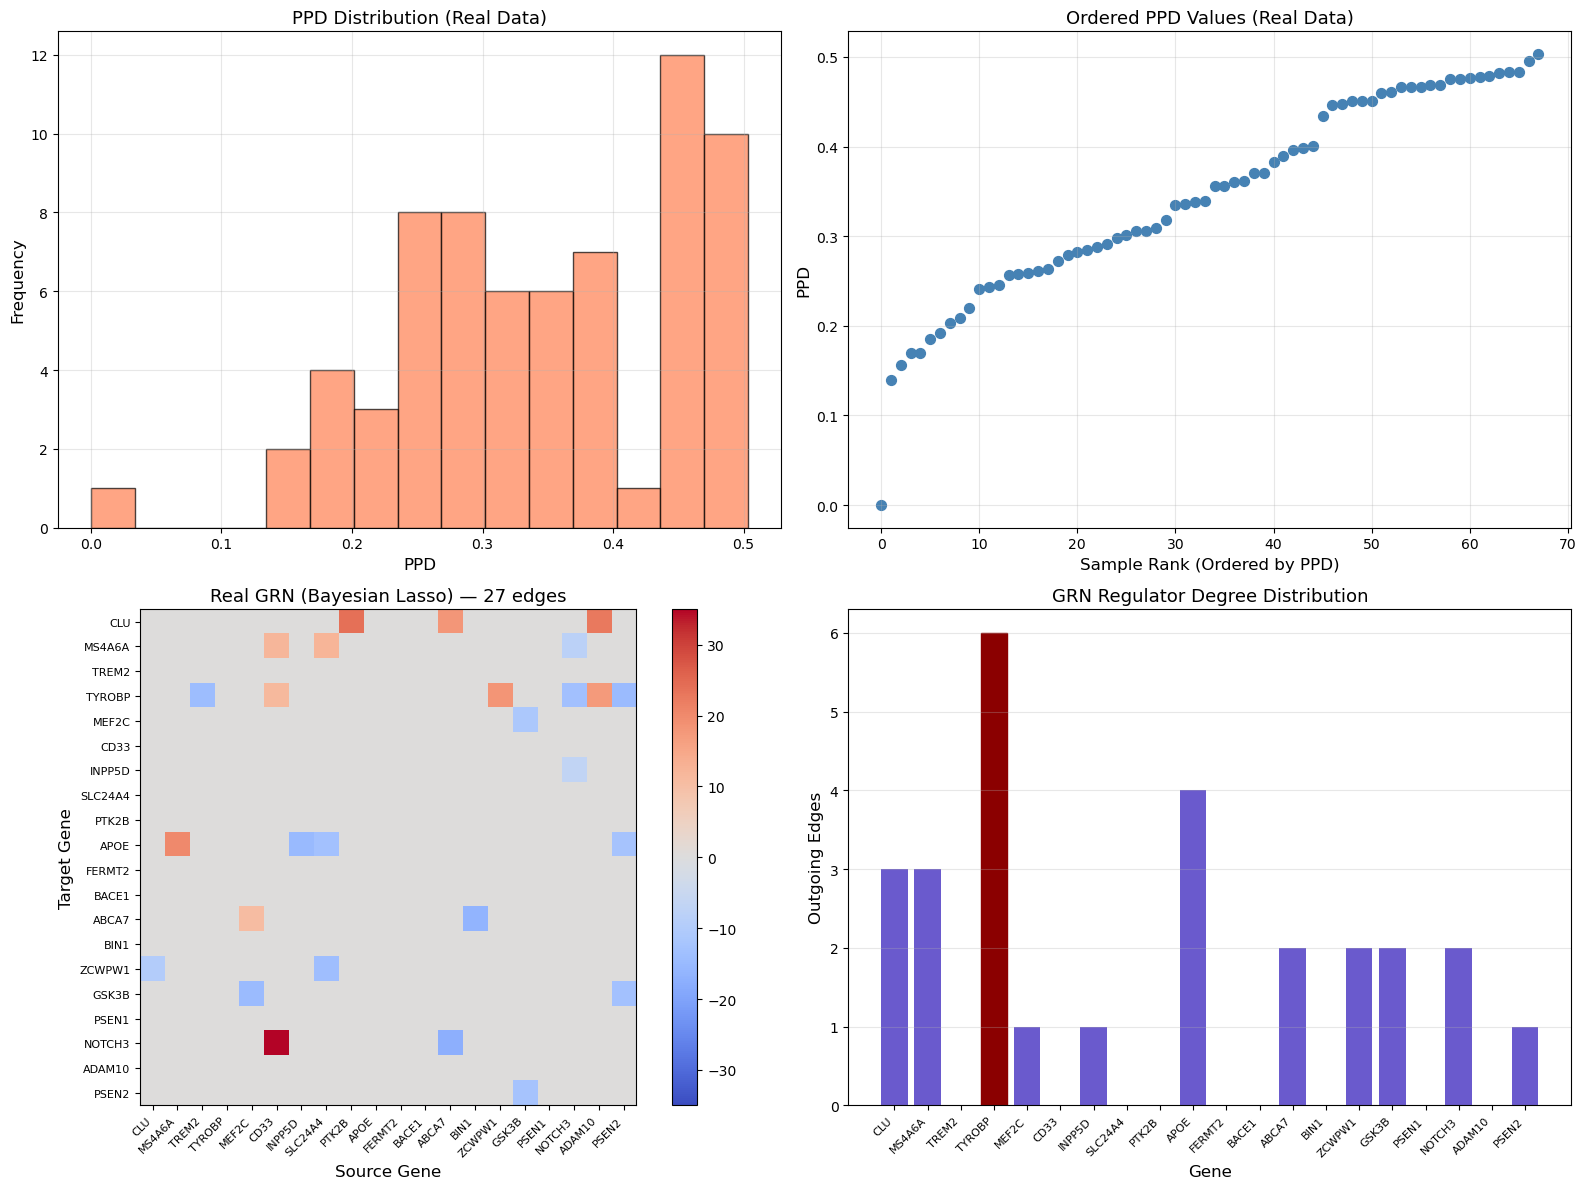

In [21]:
# PROB Results on GSE48350 Data
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram of PPD (real data)
ax = axes[0, 0]
ax.hist(PPD_real, bins=15, alpha=0.7, edgecolor='black', color='coral')
ax.set_xlabel('PPD', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('PPD Distribution (Real Data)', fontsize=13)
ax.grid(True, alpha=0.3)

# Rank-order pseudotime vs actual PPD values
# (acts as an analog to synthetic "true progression")
ax = axes[0, 1]
rank_order = np.argsort(PPD_real)
ax.scatter(np.arange(len(PPD_real)), PPD_real[rank_order], s=50, color='steelblue')
ax.set_xlabel('Sample Rank (Ordered by PPD)', fontsize=12)
ax.set_ylabel('PPD', fontsize=12)
ax.set_title('Ordered PPD Values (Real Data)', fontsize=13)
ax.grid(True, alpha=0.3)

# Real GRN (AM_real heatmap)
ax = axes[1, 0]
vmax_real = np.max(np.abs(AM_real))
im = ax.imshow(AM_real, cmap='coolwarm', vmin=-vmax_real, vmax=vmax_real)
ax.set_title(f'Real GRN (Bayesian Lasso) — {np.sum(AM_real != 0)} edges', fontsize=13)
ax.set_xlabel('Source Gene', fontsize=12)
ax.set_ylabel('Target Gene', fontsize=12)

ax.set_xticks(np.arange(len(genes_of_interest)))
ax.set_yticks(np.arange(len(genes_of_interest)))
ax.set_xticklabels(genes_of_interest, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(genes_of_interest, fontsize=8)

plt.colorbar(im, ax=ax)

# Node out-degree distribution (regulators)
ax = axes[1, 1]
out_degrees = np.sum(AM_real != 0, axis=1)
bars = ax.bar(np.arange(len(out_degrees)), out_degrees, color='slateblue')
ax.set_xlabel('Gene', fontsize=12)
ax.set_ylabel('Outgoing Edges', fontsize=12)
ax.set_title('GRN Regulator Degree Distribution', fontsize=13)
ax.set_xticks(np.arange(len(genes_of_interest)))
ax.set_xticklabels(genes_of_interest, rotation=45, ha='right', fontsize=8)
ax.grid(True, alpha=0.3, axis='y')

# Highlight top regulators
max_degree = np.max(out_degrees)
if max_degree > 0:
    for i, (bar, deg) in enumerate(zip(bars, out_degrees)):
        if deg == max_degree:
            bar.set_color('darkred')

plt.tight_layout()
plt.show()
